# Multidimensional Analysis of Synaptic Proteins

In this notebook we go through the multidimensional analyis of synaptic proteins that was created for the following paper : _Activity-dependent remodelling of synaptic protein organization revealed by high throughput analysis of STED nanoscopy images_.

Here are the sections of the analysis:
* [Define functions](#define-functions)
* [Define constants](#define-constants)
* [Dimensionality reduction from UMAP](#reduce-umap)
* [Hierarchical clustering](#hierarchical-clustering)
* [Associate cluster](#associate-cluster)

__Please cite this analysis pipeline using the following bibtex entry__.
```
@article{Wiesner2020,
  title={Activity-dependent remodelling of synaptic protein organization revealed by high throughput analysis of STED nanoscopy images},
  author={Wiesner, Theresa and Bilodeau, Anthony and Bernatchez, Renaud and Raulier, Bastian and De Koninck, Paul and Lavoie-Cardinal, Flavie},
  journal={Frontiers in Neural Circuits},
  volume={},
  number={},
  pages={},
  year={2020},
  publisher={Frontiers}
}
```

In [1]:
%matplotlib inline
import numpy 
import os
import warnings
import matplotlib 
import pickle 
import random
import pandas 

from IPython.display import display, HTML
from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from collections import defaultdict
from umap import UMAP
from matplotlib import pyplot, lines, gridspec
from seaborn.distributions import _scipy_bivariate_kde
from skimage import filters, transform, feature, measure

# Sets random seed for reproducibility
random.seed(42)
numpy.random.seed(42)

<a id='define-functions'></a>
## Define functions 

The following functions are used throughout the notebook

In [2]:
def load_data(plasticity, condition, chan, keep_features):
    """
    Loads the data and only keeps the coupled clusters
    
    :param plasticity: A `str` of the plasticity
    :param condition: A `str` of the condition to load 
    :param chan: An `int` of the channel to load
    :param keep_features: A `list` of integers of features to keep from file
    
    :returns : A `numpy.ndarray` of the data 
    """
    data = numpy.load(f"./data/{plasticity}-plasticity-pfile/{condition}-chan{chan}.npy", allow_pickle=True)
    
    X = []
    for _data in data:
        coupled = _data[:, 13].astype(bool)
        coupled = _data[coupled, :]
        coupled = coupled[:, keep_features]

        X.append(coupled)
    return numpy.concatenate(X, axis=0)

class Grid:
    """
    Creates a `Grid` object to store each data point in a specific cell.
    This allows to then compute statistics on specific region of the
    data points.
    """
    def __init__(self, xlim, ylim, gridsize):
        """
        Instantiate a `Grid` object

        :param xlim: A `tuple` of x limits
        :param ylim: A `tuple` of y limits
        :param gridsize: The number of cells along each axis
        """
        self.xlim = xlim
        self.ylim = ylim
        self.gridsize = gridsize

        self.grid = self.create_grid()
        self.xticks = numpy.linspace(*xlim, gridsize)
        self.yticks = numpy.linspace(*ylim, gridsize)

    def clear_grid(self):
        """
        Method to clear the grid
        """
        self.grid = self.create_grid()

    def create_grid(self):
        """
        Method to create an empty grid

        :returns : An empty grid
        """
        grid = [[[] for _ in range(self.gridsize)] \
                    for _ in range(self.gridsize)]
        return grid

    def add_data(self, ijk):
        """
        Method to add data points to the grid

        :param ijk: A list of `tuple` with (x, y) coordinates and value to append
        """
        for i, j, k in ijk:
            i_index = int((i - self.xlim[0]) / ((self.xlim[1] - self.xlim[0]) / self.gridsize))
            j_index = int((j - self.ylim[0]) / ((self.ylim[1] - self.ylim[0]) / self.gridsize))
            if (i_index < 0) or (i_index >= self.gridsize) or (j_index < 0) or (j_index >= self.gridsize):
                continue
            self.grid[j_index][i_index].append(k)

    def compute_stats(self, method=None):
        """
        Method to compute statistics on every cell of the grid

        :param method: (optional) A `function` to compute statistics. This `function`
                       should accept `list` as input. If None `numpy.mean` is selected

        :returns : A `numpy.ndarray` of the statistics on each cell of the grid
        """
        if isinstance(method, (type(None))) or (not isinstance(method, (type(numpy.mean)))):
            method = numpy.mean
        output_grid = []
        for rows in self.grid:
            output_cols = []
            for cols in rows:
                output_cols.append(method(cols) if cols else 0)
            output_grid.append(output_cols)
        return numpy.array(output_grid)

def get_norm(keep_features):
    """
    Computes the normalization of all features for all data with 0.05 and 0.95 quantiles
    
    :param keep_features: A `list` of integers of features to keep 
    
    :param : A `numpy.ndarray` of minimal values for each features
             A `numpy.ndarray` of maximal values for each features
    """
    conditions = [
        ("synaptic", "block"),
        ("synaptic", "0mgglybic"),
        ("synaptic", "glugly"),
        ("homeostatic", "ctrl"),
        ("homeostatic", "4hTTX"),
        ("homeostatic", "24hTTX"),
        ("homeostatic", "48hTTX")
    ]
    all_data = []
    for chan in [1, 2]:
        for (plasticity, cond) in conditions:
            data = load_data(plasticity, cond, chan, keep_features)
            all_data.append(data)
    all_data = numpy.concatenate(all_data, axis=0)
    vmin, vmax = numpy.quantile(all_data, q=[0.05, 0.95], axis=0)
    return vmin, vmax

def associate(subtypes, labels, plasticity, condition, chan, keep_features):
    """
    Associate each cluster with averaged cluster maximas
    
    :param subtypes: A `numpy.ndarray` of size (N, len(keep_features))
    :param labels: A `numpy.ndarray` of size (N,) of the labels associated for each average cluster
    :param plasticity: A `str` of the plasticity
    :param condition: A `str` of the condition to load 
    :param chan: An `int` of the channel to load
    :param keep_features: A `list` of integers of features to keep from file
    
    :returns : Number of synaptic subtypes per image
               Distance of association
    """
    data = numpy.load(f"./data/{plasticity}-plasticity-pfile/{condition}-chan{chan}.npy", allow_pickle=True)

    subtypes = (subtypes - _min) / (_max - _min)
    density_per_image, association_distance = [], []
    for _data in data:        
        coupled = _data[:, 13].astype(bool)
        _data = _data[coupled, :]
        _data = _data[:, :]
        
        tmp = (_data[:, keep_features] - _min) / (_max - _min)
        distances = distance.cdist(subtypes, tmp, metric="euclidean")
        associated_subtype = labels[numpy.argmin(distances, axis=0)]
        ids, counts = numpy.unique(associated_subtype, return_counts=True)
        number_subtype = numpy.zeros(labels.max() + 1)
        number_subtype[ids] += counts
        density_per_image.append(number_subtype)
        
        association_distance.extend(numpy.min(distances, axis=0))

    return numpy.array(density_per_image), association_distance

<a id='define-constants'></a>
## Define constants

We define constants that will be used throughout the notebook.

In [3]:
# Creates the default cmap instance
CMAP = pyplot.cm.YlGnBu

# Defines the channel to analyse {1, 2}
CHAN = 1

# Defines wheter the users want to save the trained mapper
SAVE_MAPPER = False

# Defines the default colors 
COLORS = {
    "synaptic, block" : "black",
    "synaptic, 0mgglybic" : "darkseagreen",
    "synaptic, glugly" : "peru"
}

# Defines the decision maps colormap
DECISION_MAPS = {
    "block" : matplotlib.colors.LinearSegmentedColormap.from_list("decisionmap", ["white", COLORS["synaptic, block"]]),
    "0mgglybic" : matplotlib.colors.LinearSegmentedColormap.from_list("decisionmap", ["white", COLORS["synaptic, 0mgglybic"]]),
    "glugly" : matplotlib.colors.LinearSegmentedColormap.from_list("decisionmap", ["white", COLORS["synaptic, glugly"]])
}

# Defines the condition to use in the notebook 
CONDITIONS = [
    ("synaptic", "block"),
    ("synaptic", "0mgglybic"),
    ("synaptic", "glugly")
]

# Defines the available columns in the xlsx files
KEYS = ['X', 'Y', 'Area', 'Distance to Neighbor Same Ch',
       'Distance to Other Ch', 'Eccentricity', 'Max intensity',
       'Min intensity', 'Mean intensity', 'Major axis length',
       'Minor axis length', 'Orientation', 'Perimeter', 'Coupled', 'Coupling Prob']

# Defines the features to keep
KEEP_FEATURES = [2, 4, 5, 9, 10, 12, 14]

# Defines the min and max value of the KDE plots
VMIN, VMAX = get_norm(KEEP_FEATURES)
VMIN[[1, 2, -1]] = [0, 0.4, 0] # Specifies min values
VMAX[[1, 2, -1]] = [12, 1., 1] # Specifies max values

<a id='load-data'></a>
## Load data

We now load the data from the selected `CHAN` and computes the statistics

In [4]:
# Loads the complete data, label and colors
X, y, c = [], [], []
for i, (plasticity, cond) in enumerate(CONDITIONS):
    coupled = load_data(plasticity, cond, CHAN, KEEP_FEATURES)

    X.append(coupled)
    y.append(numpy.repeat(i, len(X[-1])))
    c.append([COLORS[f"{plasticity}, {cond}"] for _ in range(len(X[-1]))])
X, y, c = map(lambda _list : numpy.concatenate(_list, axis=0), (X, y, c))

# Normalizes the data with a min max scale
_min, _max = X.min(axis=0), X.max(axis=0)
X = (X - _min) / (_max - _min)

<a id='reduce-umap'></a>
## Dimensionality reduction from UMAP

The users should decide wheter they want to fit a mapper from scratch or use the provided mappers

In [ ]:
# Fit a mapper from scratch
with warnings.catch_warnings(): # Raises a numba parallel warning
    warnings.simplefilter("ignore")
    mapper = UMAP(n_components=2, n_neighbors=25, min_dist=0.05, init="spectral", transform_seed=42)
    mapper = mapper.fit(X)

if SAVE_MAPPER:
    pickle.dump(mapper, open(os.path.join("mappers", f"mapper-{CONDITIONS[0][0]}-{CHAN}-fit.pkl"), "wb"))

KeyboardInterrupt: 

In [5]:
# Loads a previous mapper
mapper = pickle.load(open(f"mappers/mapper-{CONDITIONS[0][0]}-{CHAN}.pkl", "rb"))

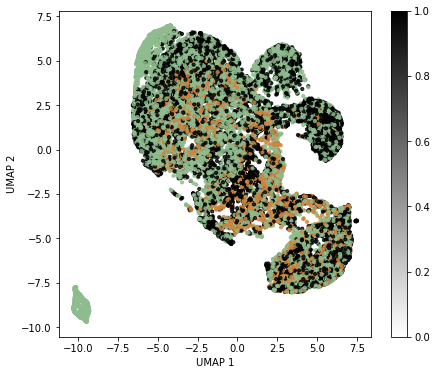

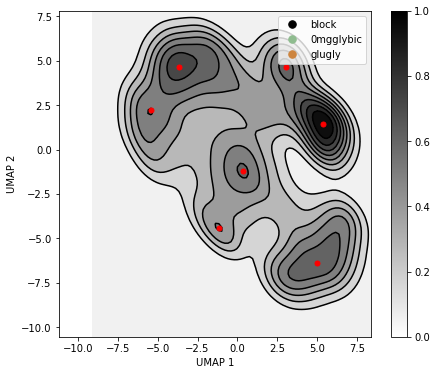

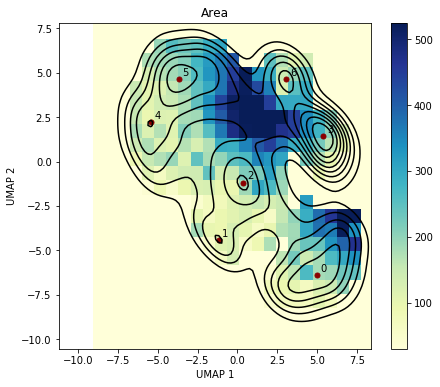

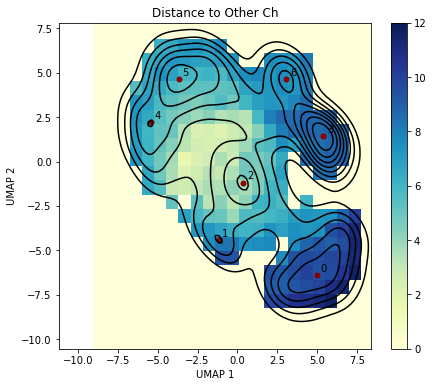

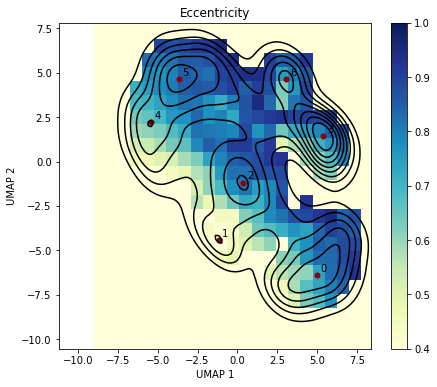

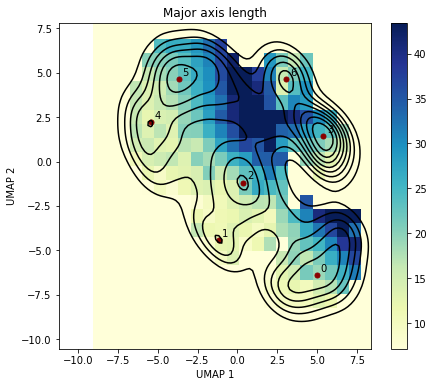

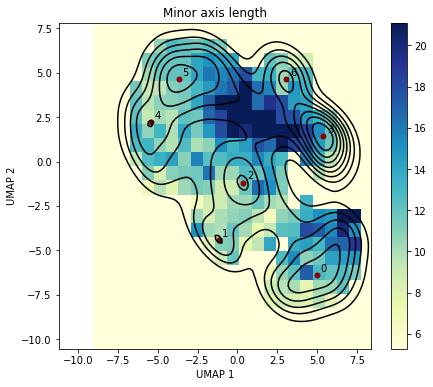

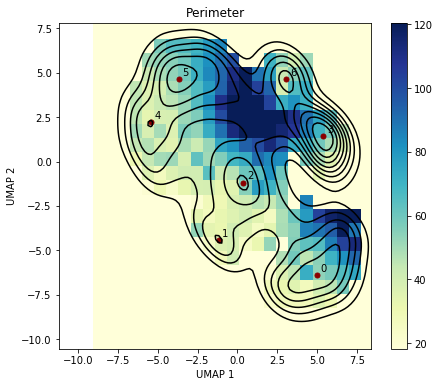

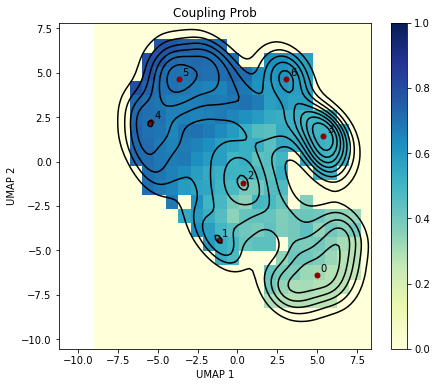

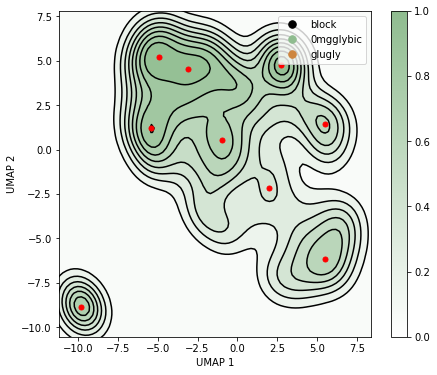

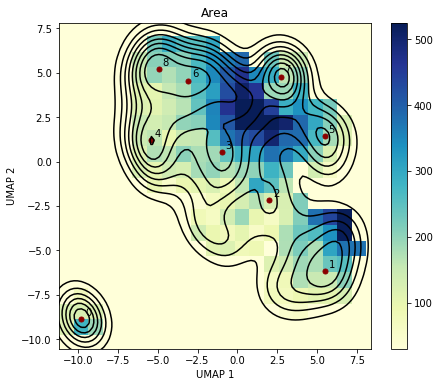

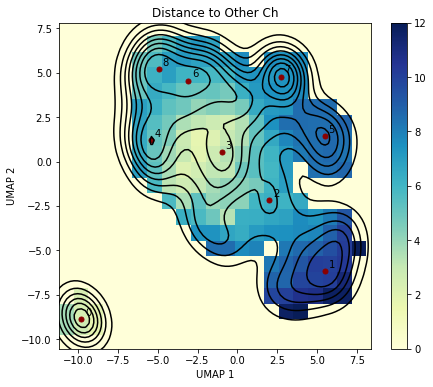

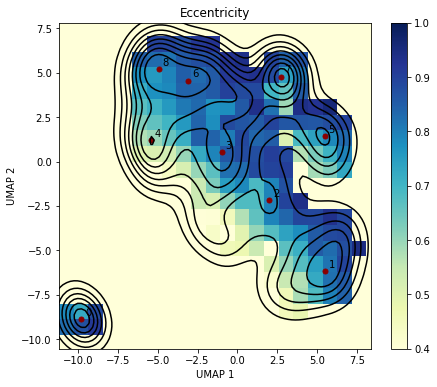

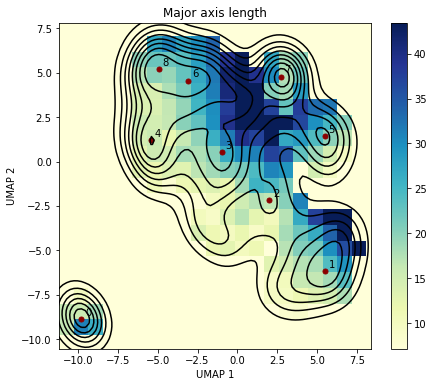

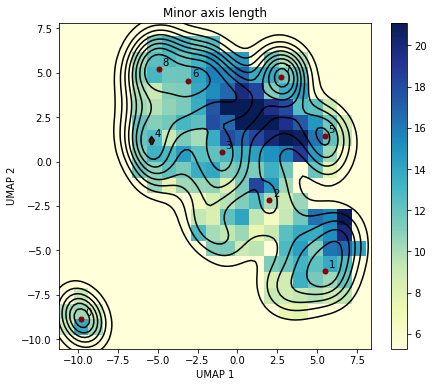

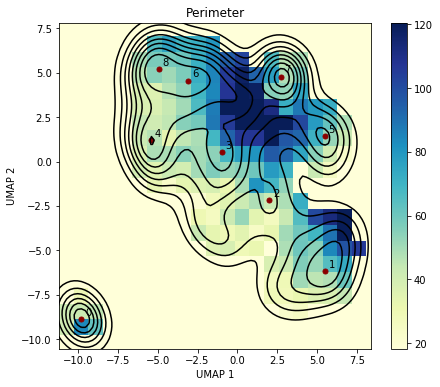

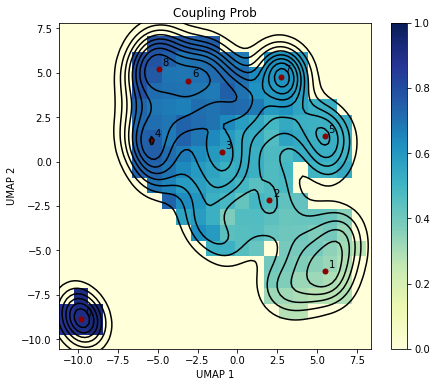

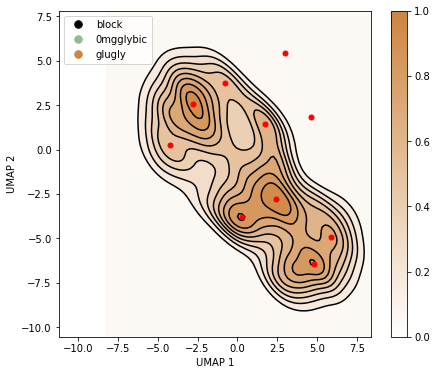

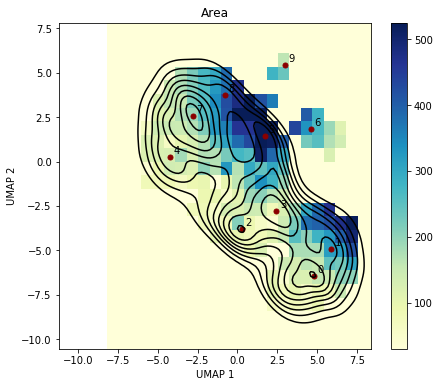

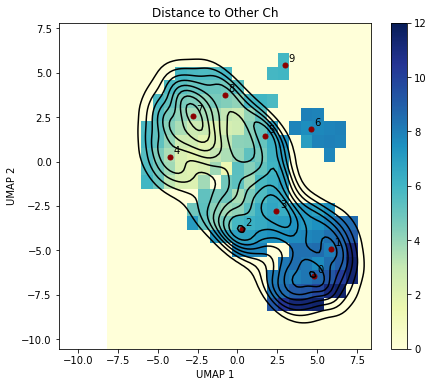

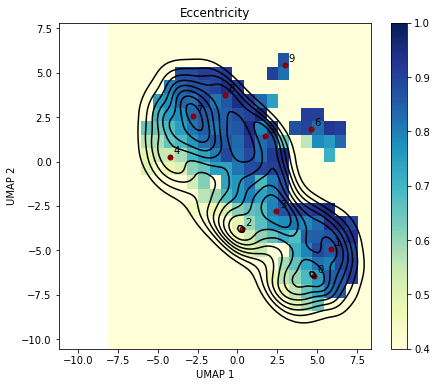

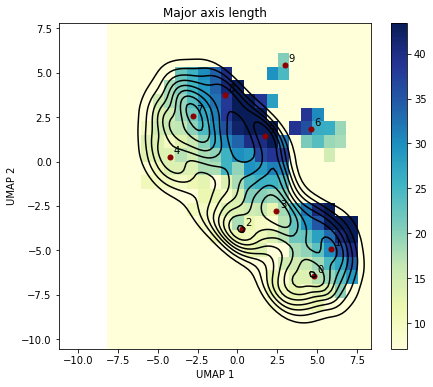

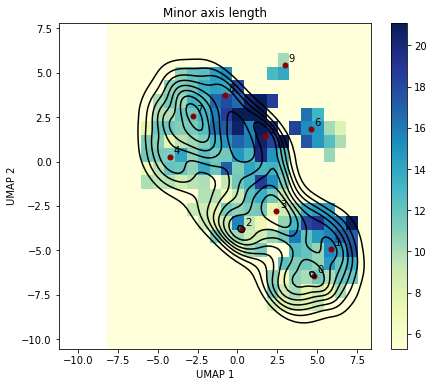

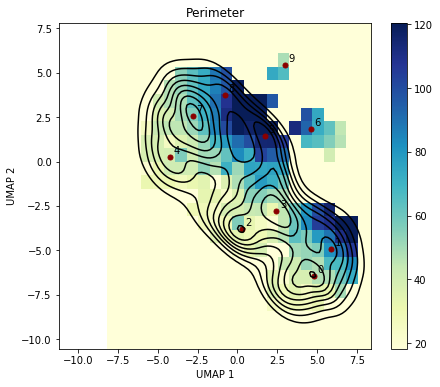

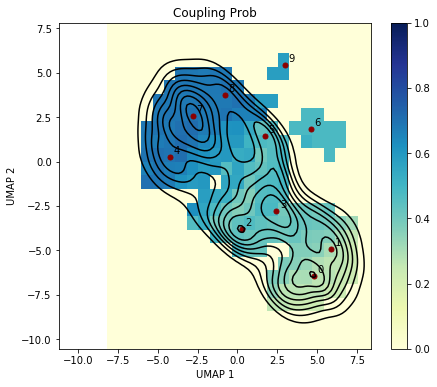

In [6]:
# Transforms the data
X_transformed = mapper.transform(X)

# Plots the transformed data on a matplotlib figure
fig, ax = pyplot.subplots(figsize=(7, 6))
samples = numpy.random.choice(X.shape[0], size=X.shape[0], replace=False) # Shuffles the points
points = ax.scatter(*X_transformed[samples].T, c=c[samples], cmap=CMAP, alpha=0.8, s=10)
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
pyplot.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=DECISION_MAPS["block"]), ax=ax) # creates a dummy instance of colorbar
handles = [lines.Line2D([], [], linestyle="None", marker='.', markersize=15, color=COLORS[f"{plasticity}, {cond}"], label=cond)
           for i, (plasticity, cond) in enumerate(CONDITIONS)]
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
pyplot.show()

# Defines the xlim and ylim for all subsequent figures
xlim, ylim = ax.get_xlim(), ax.get_ylim()

total_maximas, total_colors = [], []
for i, (plasticity, cond) in enumerate(CONDITIONS):
    
    # Density calculation
    _x, _y = X_transformed[y==i].T
    xx, yy, density = _scipy_bivariate_kde(_x, _y, bw="scott", gridsize=100,
                                                    cut=3, clip=[(-numpy.inf, numpy.inf), (-numpy.inf, numpy.inf)])
               
    # Finding local maxima of density 
    coordinates = feature.peak_local_max(density, min_distance=1, threshold_abs=0, indices=False)
    xpts, ypts = xx[coordinates], yy[coordinates]
    
    # Defines levels to plot the contour
    levels = numpy.linspace(0, density.max(), num=10)
    
    # Plots the KDE maps with countour 
    fig, ax = pyplot.subplots(figsize=(7, 6))
    ax.scatter(xpts, ypts, c="r", s=25, zorder=3)
    cf = ax.contourf(xx, yy, density, levels=levels, cmap=DECISION_MAPS[cond])
    ax.contour(cf, colors="k")
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    pyplot.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=DECISION_MAPS[cond]), ax=ax)
    handles = [lines.Line2D([], [], linestyle="None", marker='.', markersize=15, color=COLORS[f"{plasticity}, {cond}"], label=cond)
               for i, (plasticity, cond) in enumerate(CONDITIONS)]
    ax.legend(handles=handles)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    pyplot.show()

    # Creates grid instance to compute local features
    grid = Grid((xx.min(), xx.max()), (yy.min(), yy.max()), 25)
    maxima_values, color_values = {}, {}
    for j, kf in enumerate(KEEP_FEATURES):
        
        # Adds data to grid and computes stats
        ijk = numpy.stack((_x, _y, (X * (_max - _min) + _min)[y == i, j])).T
        grid.add_data(ijk)
        grid_stats = grid.compute_stats(method=numpy.mean)
        grid_stats = grid_stats.repeat(100 // 25, axis=0).repeat(100 // 25, axis=1)
        
        # Unnormalize data values
        vmin = X[y == i, :].min() * (_max - _min) + _min
        vmax = X[y == i, :].max() * (_max - _min) + _min
        norm = matplotlib.colors.Normalize(vmin=VMIN[j], vmax=VMAX[j])
        
        # Gets the maxima values of features at each coordinates
        maxima_values[KEYS[kf]] = grid_stats[coordinates]
        
        # Converts maxima values to rgb color
        color_values[KEYS[kf]] = ["{}, {}, {}".format(*(c[:3] * 255).astype(int)) for c in CMAP((grid_stats[coordinates] - VMIN[j]) / (VMAX[j] - VMIN[j]))]
        
        # Plots local mean feature, KDE contour and local maxima
        fig, ax = pyplot.subplots(figsize=(7, 6))
        ax.set_title(KEYS[kf])
        xpts, ypts = xx[coordinates], yy[coordinates]
        trans_offset = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=0.05, y=0.05)
        for _id, (xpt, ypt) in enumerate(zip(xpts, ypts)):
            ax.scatter(xpt, ypt, s=25, c="darkred")
            ax.text(xpt, ypt, str(_id), transform=trans_offset)
        pyplot.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=CMAP), ax=ax)
        ax.imshow(grid_stats, origin="lower", extent=(*grid.xlim, *grid.ylim),
                    aspect="auto", cmap=CMAP, norm=norm)
        ax.contour(cf, colors="k", levels=levels[:])
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        pyplot.show()
        
        # Clears grid 
        grid.clear_grid()
    
    # Keeps track of maxima values and color values
    total_maximas.append(maxima_values)
    total_colors.append(color_values)


<a id='hierarchical-clustering'></a>
## Hierarchical clustering

In this section we perform the hierarchical clustering of the synaptic subtypes.

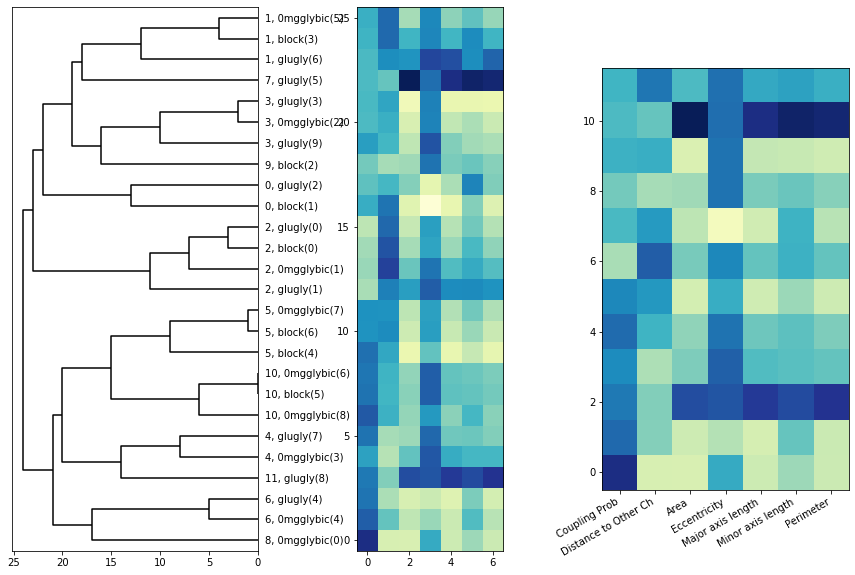

In [7]:
# Defines the keys order
keys_order = [6, 1, 0, 2, 3, 4, 5]

# Combines the maximas in a single numpy.ndarray 
maximas, labels = defaultdict(list), []
for (_dict, (plasticity, cond)) in zip(total_maximas, CONDITIONS):
    labels.extend(f"{cond}({i})" for i in range(list(_dict.values())[0].size))
    for key, values in _dict.items():
        maximas[key].extend(values)
maximas = numpy.array(list(maximas.values())).T

# Combines colors in a single numpy.ndarray
_colors = defaultdict(list)
for _dict in total_colors:
    for key, values in _dict.items():
        _colors[key].extend([list(map(int, v.split(", "))) for v in values])
_colors = numpy.transpose(numpy.array(list(_colors.values())), axes=(1, 0, 2))

# Clustering
_X = (maximas - _min) / (_max - _min)
clustering = AgglomerativeClustering(n_clusters=12 if CHAN == 1 else 8, 
                                        affinity="euclidean", linkage="ward").fit(_X)

# Hierchiarchical clustering
children = clustering.children_
dist = numpy.arange(children.shape[0])
no_of_observations = numpy.arange(2, children.shape[0]+2)
Z = numpy.column_stack([children, dist, no_of_observations]).astype(float)
hierarchy.set_link_color_palette(["k"])
labels = [", ".join((str(l2), str(l1))) for l1, l2 in zip(labels, clustering.labels_)]

# Plots dendogram
gs = gridspec.GridSpec(1, 3, height_ratios=[1])
fig = pyplot.figure(figsize=(15, 10))
axes = [pyplot.subplot(_gs) for _gs in gs]
dn = hierarchy.dendrogram(Z, ax=axes[0], labels=labels, orientation="left", above_threshold_color='k', color_threshold=15)

# Average same cluster synapse
clabel = []
for cl in clustering.labels_[dn["leaves"]]:
    if cl not in clabel:
        clabel.append(cl)
average_cluster, mean_clustering_labels = [], []
for cl in clabel:
    averages = numpy.mean(maximas[clustering.labels_ == cl], axis=0)
    mean_clustering_labels.append(averages)
    avg_cluster = []
    for i, avg in enumerate(averages):
        norm = matplotlib.colors.Normalize(vmin=VMIN[i], vmax=VMAX[i])
        scalarmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=CMAP)
        avg_cluster.append(scalarmap.to_rgba(avg))
    average_cluster.append(avg_cluster)
average_cluster = numpy.array(average_cluster)
average_cluster = average_cluster[:, keys_order, :]

# Plots averaged same cluster synapses
axes[2].imshow(average_cluster, origin="lower")
axes[1].imshow(_colors[dn["leaves"]][:, keys_order, :], origin="lower")
xticklabels = numpy.array(KEEP_FEATURES)[keys_order]
xticklabels = numpy.array(KEYS)[xticklabels]
axes[2].set_xticks(numpy.arange(len(xticklabels)))
axes[2].set_xticklabels(xticklabels, rotation=30, horizontalalignment="right")
pyplot.show()

<a id='associate-cluster'></a>
## Associate clusters

We associate each cluster to a subtype

In [8]:
output = defaultdict(dict)
for (plasticity, cond) in CONDITIONS:
    density_per_image, association_distance = associate(maximas, clustering.labels_, plasticity, cond, CHAN, KEEP_FEATURES)
    output["density"][cond] = density_per_image
    output["distances"][cond] = association_distance